In [1]:
# !pip install scipy
# !pip install graphviz
# !pip install xgboost
# !pip install kaggle
# !pip install kagglehub

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap 

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.inspection import permutation_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost

from graphviz import Source
from sklearn import tree
from IPython.display import SVG

import itertools

from sklearn.ensemble import BaggingClassifier

## Downloading, Studying and Cleaing

In [4]:
# Initialize Kaggle's API
api = KaggleApi()
api.authenticate()

In [5]:
# Download the dataset
dataset = 'manidevesh/hr-dataset-analysis'
download_path = './hr_dataset'  # Folder where the CSV will be saved
api.dataset_download_files(dataset, path=download_path, unzip=True)

file_name = [f for f in os.listdir(download_path) if f.split('.')[1]=='csv'][0]
print("Download complete. File name is: {}".format(file_name))


Dataset URL: https://www.kaggle.com/datasets/manidevesh/hr-dataset-analysis
Download complete. File name is: HR_DataSet.csv


In [6]:
# Download the dataset
Data = pd.read_csv(os.path.join(download_path, file_name))

In [7]:
display(Data.head())

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [8]:
# There are no Nulls!
display(Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


None

In [9]:
# Number of duplicates
print(Data[Data.duplicated(list(Data.columns))].shape[0])

3008


In [10]:
# Example of duplicates
display(Data.query('satisfaction_level == 1.00 and last_evaluation == 0.93 and Department == "marketing"'))

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
10691,1.0,0.93,5,231,2,0,0,0,marketing,medium
12902,1.0,0.93,5,231,2,0,0,0,marketing,medium


#### I decided to keep the duplicates since for the given amount of data it may represent two different datapoints with coinciding inputs!

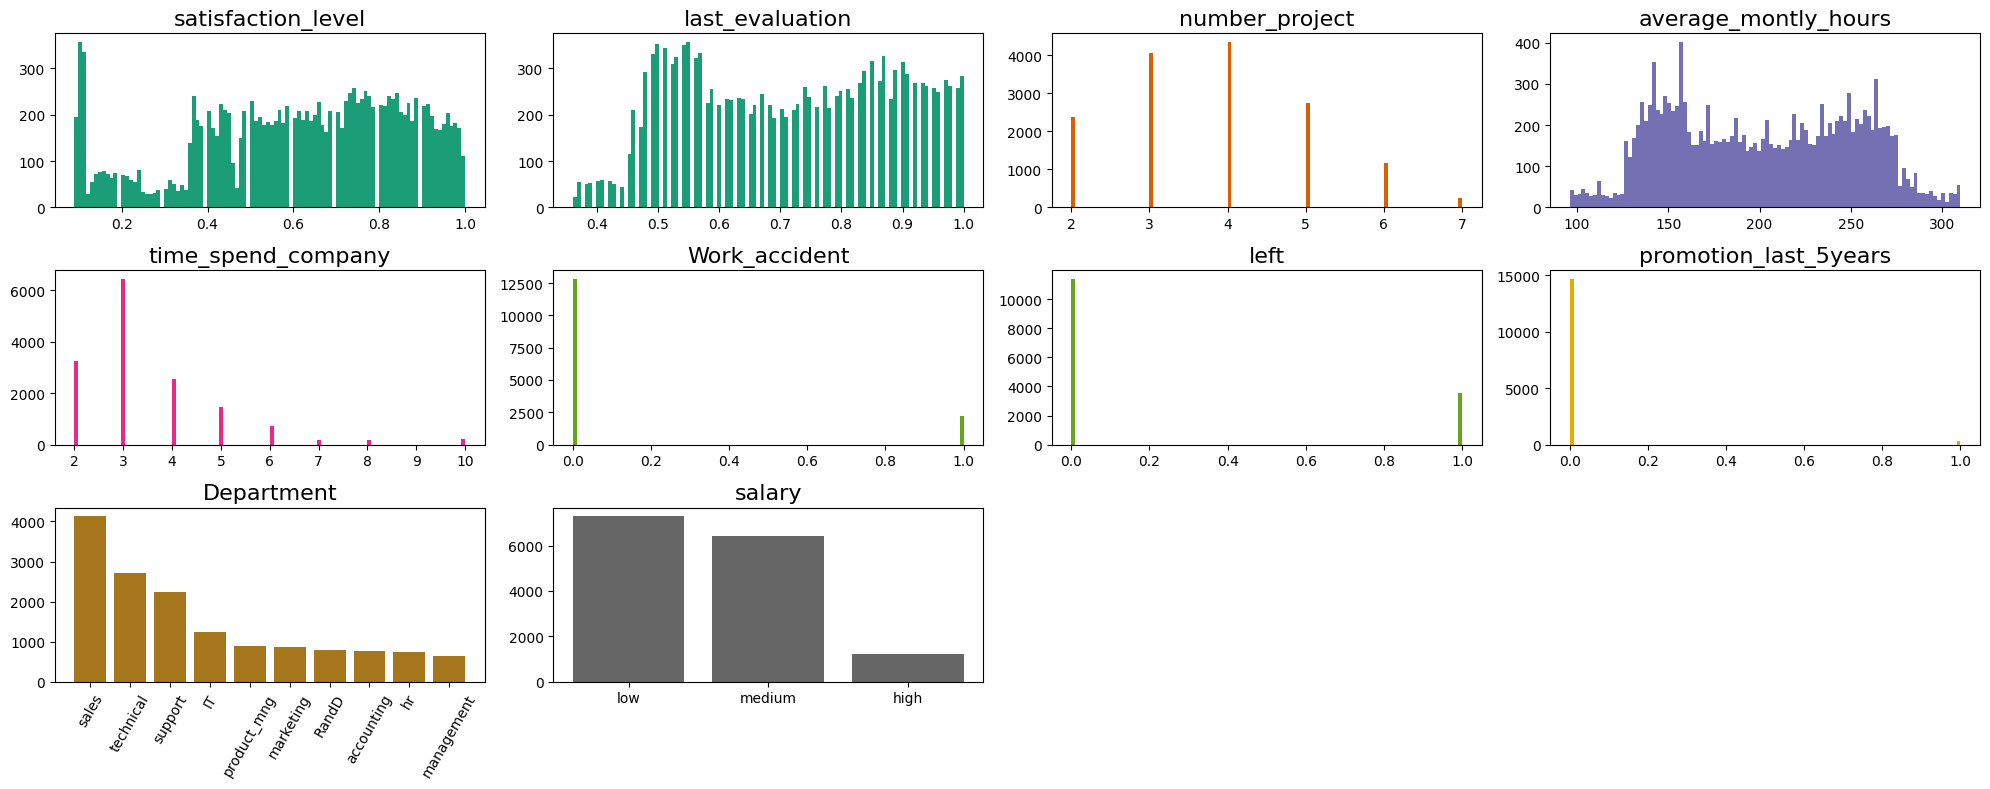

In [11]:
# Histograms
fig = plt.figure(figsize = (20, 8))
for idx, col, t in Data.dtypes.reset_index().reset_index().values:
    color = plt.colormaps.get_cmap('Dark2')(idx / Data.columns.size)
    if t == 'object':
        fig.add_subplot(3, 4, idx + 1).bar(*zip(*Data[col].value_counts().reset_index().values), color=color)
        if Data[col].nunique() > 5:
            plt.xticks(rotation = 60)
    else:
        fig.add_subplot(3, 4, idx + 1).hist(Data[col], bins = 100, color=color)
    plt.title(col, fontsize=16)
plt.tight_layout()
plt.show()
del(idx, col, fig)

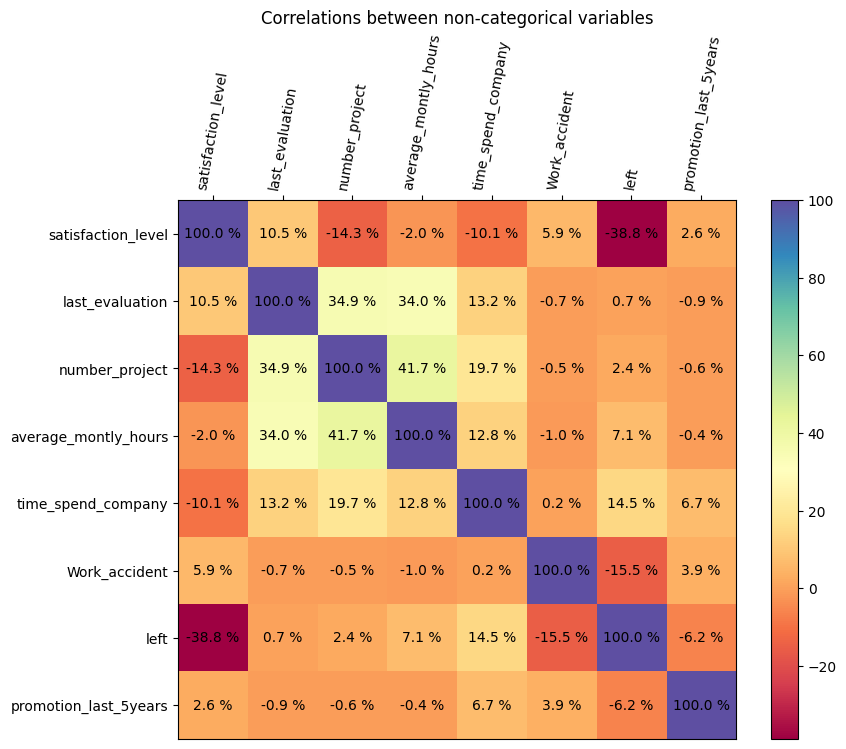

In [12]:
# Correlations
plt.figure(figsize = (9, 7))
        
corr_data = Data.select_dtypes(["int","float"]).corr() * 100
plt.imshow(corr_data, cmap='Spectral', aspect='auto', origin='upper')
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

plt.xticks(*list(zip(*enumerate(corr_data.columns))), rotation=80)
plt.yticks(*list(zip(*enumerate(corr_data.columns))), rotation=0)

for y in range(corr_data.shape[0]):
    for x in range(corr_data.shape[1]):
        plt.text(x, y,'{:.1f} %'.format(corr_data.values[y, x]),
                 horizontalalignment='center',
                 verticalalignment='center')
        
plt.colorbar()
plt.title('Correlations between non-categorical variables')
plt.show()
del(x , y, corr_data)

## Splitting the data

In [13]:
X = Data.drop('left', axis = 1)
y = Data['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic regression

In [14]:
preprocess_pipeline =  ColumnTransformer(transformers = [('numerical', StandardScaler(),  Data.drop('left', axis = 1).select_dtypes(['float','int']).columns), 
                                                         ('categorical', OneHotEncoder(), Data.select_dtypes(['object']).columns)],
                                         remainder='passthrough')

logistic_regression_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), ('classifier', LogisticRegression())])
logistic_regression_pipeline.fit(X_train, y_train)

y_pred = logistic_regression_pipeline.predict(X_test)

print("Logistic regression accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic regression accuracy: 0.7843
Confusion matrix:
[[2116  178]
 [ 469  237]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2294
           1       0.57      0.34      0.42       706

    accuracy                           0.78      3000
   macro avg       0.69      0.63      0.65      3000
weighted avg       0.76      0.78      0.76      3000



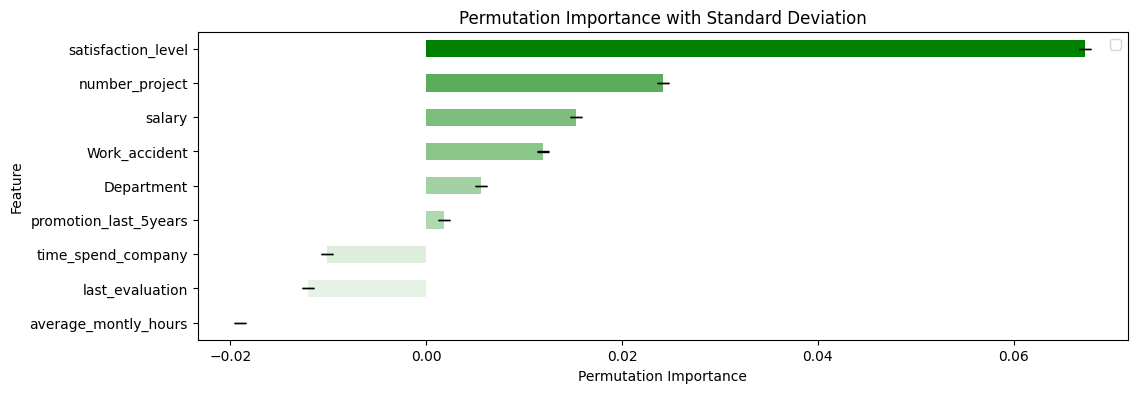

In [15]:
# Feature importance
cmap = LinearSegmentedColormap.from_list('Green',["w", "g"], N=256)

result = permutation_importance(logistic_regression_pipeline, X_test, y_test, n_repeats=100, random_state=42)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean,  
                                   'Standard Deviation': result.importances_std}).sort_values('Importance', ascending=True)

feature_importance.plot(x = 'Feature', y = 'Importance', kind = 'barh', figsize = (12, 4), yerr='Standard Deviation', capsize=4, align='center', legend = False,
                        color = cmap(((feature_importance['Importance']-feature_importance['Importance'].min()) / feature_importance['Importance'].max() * 256
                                     ).map(int)))
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance with Standard Deviation')
plt.legend("")

plt.show()
del(cmap, result, feature_importance, logistic_regression_pipeline)

## Decison Trees

In [16]:
decision_tree_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))])

decision_tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  Index(['Department', 'salary'], dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

In [25]:
# Showing the tree
SVG(Source(tree.export_graphviz(decision_tree_pipeline.named_steps['classifier'], out_file=None, filled=True,
                                feature_names=decision_tree_pipeline.named_steps['preprocessor'].get_feature_names_out(), 
                                class_names=[str(c) for c in decision_tree_pipeline.classes_]
                               )).pipe(format='svg'))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [24]:
import os
#print(os.environ["PATH"])
print([f for f in os.environ["PATH"] if 'Graph' in f])

[]


In [ ]:
y_pred = decision_tree_pipeline.predict(X_test)

print("Decision Tree accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
del(y_pred)

Decision Tree accuracy: 0.9713
Confusion matrix:
[[2263   31]
 [  55  651]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2294
           1       0.95      0.92      0.94       706

    accuracy                           0.97      3000
   macro avg       0.97      0.95      0.96      3000
weighted avg       0.97      0.97      0.97      3000



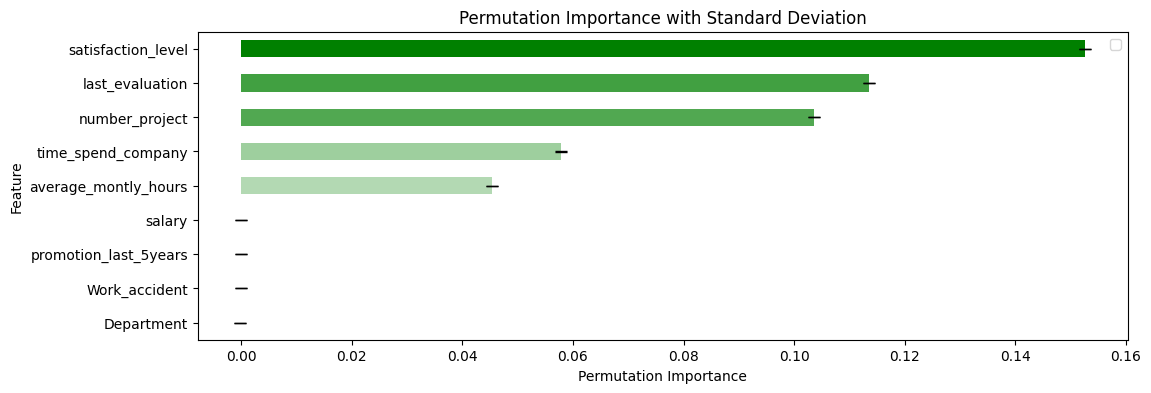

In [ ]:
# Feature importance
cmap = LinearSegmentedColormap.from_list('Green',["w", "g"], N=256)

result = permutation_importance(decision_tree_pipeline, X_test, y_test, n_repeats=100, random_state=42)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean,  
                                   'Standard Deviation': result.importances_std}).sort_values('Importance', ascending=True)

feature_importance.plot(x = 'Feature', y = 'Importance', kind = 'barh', figsize = (12, 4), yerr='Standard Deviation', capsize=4, align='center', legend = False,
                        color = cmap(((feature_importance['Importance']-feature_importance['Importance'].min()) / feature_importance['Importance'].max() * 256
                                     ).map(int)))
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance with Standard Deviation')
plt.legend("")

plt.show()
del(cmap, result, feature_importance, decision_tree_pipeline)

In [ ]:
# Various scores and averages for the varying maximal depth of the tree
D = dict()
for md in range(1, 17):
    for score, averaging in itertools.product([f1_score, precision_score, recall_score],['binary','macro','micro','weighted']):
        decision_tree_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), ('classifier', DecisionTreeClassifier(max_depth=md, random_state=42))])
        decision_tree_pipeline.fit(X_train, y_train)
        y_pred = decision_tree_pipeline.predict(X_test)
        D[(score.__name__, averaging, md)] = round(score(y_test, y_pred, average=averaging), 4)
display(pd.Series(D.values(), index = pd.MultiIndex.from_tuples(D.keys(), names=['Score','Averaging','Maximal_Depth'])).unstack([-1]))
del(D, md, score, averaging, decision_tree_pipeline, y_pred)

Maximal_Depth                  1       2       3       4       5       6   \
Score           Averaging                                                   
f1_score        binary     0.6410  0.5917  0.8980  0.9295  0.9380  0.9438   
                macro      0.7588  0.7521  0.9329  0.9541  0.9597  0.9636   
                micro      0.8163  0.8560  0.9510  0.9673  0.9713  0.9743   
                weighted   0.8212  0.8371  0.9513  0.9672  0.9712  0.9741   
precision_score binary     0.5935  0.8892  0.8803  0.9444  0.9545  0.9729   
                macro      0.7475  0.8704  0.9271  0.9593  0.9654  0.9738   
                micro      0.8163  0.8560  0.9510  0.9673  0.9713  0.9743   
                weighted   0.8290  0.8604  0.9519  0.9671  0.9712  0.9743   
recall_score    binary     0.6969  0.4433  0.9164  0.9150  0.9221  0.9164   
                macro      0.7750  0.7132  0.9390  0.9492  0.9543  0.9543   
                micro      0.8163  0.8560  0.9510  0.9673  0.9713  0.9743   
                weighted   0.8163  0.8560  0.9510  0.9673  0.9713  0.9743   

Maximal_Depth                  7       8       9       10      11      12  \
Score           Averaging                                                   
f1_score        binary     0.9475  0.9493  0.9536  0.9546  0.9465  0.9494   
                macro      0.9660  0.9671  0.9699  0.9705  0.9651  0.9670   
                micro      0.9760  0.9767  0.9787  0.9790  0.9750  0.9763   
                weighted   0.9758  0.9765  0.9785  0.9789  0.9749  0.9763   
precision_score binary     0.9760  0.9704  0.9763  0.9721  0.9540  0.9555   
                macro      0.9760  0.9744  0.9778  0.9766  0.9677  0.9691   
                micro      0.9760  0.9767  0.9787  0.9790  0.9750  0.9763   
                weighted   0.9760  0.9766  0.9786  0.9789  0.9749  0.9763   
recall_score    binary     0.9207  0.9292  0.9320  0.9377  0.9391  0.9433   
                macro      0.9569  0.9602  0.9625  0.9647  0.9626  0.9649   
                micro      0.9760  0.9767  0.9787  0.9790  0.9750  0.9763   
                weighted   0.9760  0.9767  0.9787  0.9790  0.9750  0.9763   

Maximal_Depth                  13      14      15      16  
Score           Averaging                                  
f1_score        binary     0.9540  0.9507  0.9501  0.9504  
                macro      0.9699  0.9677  0.9673  0.9674  
                micro      0.9783  0.9767  0.9763  0.9763  
                weighted   0.9783  0.9767  0.9764  0.9764  
precision_score binary     0.9533  0.9454  0.9428  0.9379  
                macro      0.9697  0.9659  0.9648  0.9633  
                micro      0.9783  0.9767  0.9763  0.9763  
                weighted   0.9783  0.9768  0.9765  0.9767  
recall_score    binary     0.9547  0.9561  0.9575  0.9632  
                macro      0.9701  0.9695  0.9698  0.9718  
                micro      0.9783  0.9767  0.9763  0.9763  
                weighted   0.9783  0.9767  0.9763  0.9763

## Bagging

In [ ]:
bagging_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                   ('classifier', BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_features=10, max_samples=1., 
                                                                    bootstrap_features=False, bootstrap=True, random_state=42, verbose=0))])
bagging_pipeline.fit(X_train, y_train)
y_pred = bagging_pipeline.predict(X_test)
print("Bagging accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
del(bagging_pipeline, y_pred)

Bagging accuracy: 0.9867
Confusion matrix:
[[2292    2]
 [  38  668]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2294
           1       1.00      0.95      0.97       706

    accuracy                           0.99      3000
   macro avg       0.99      0.97      0.98      3000
weighted avg       0.99      0.99      0.99      3000



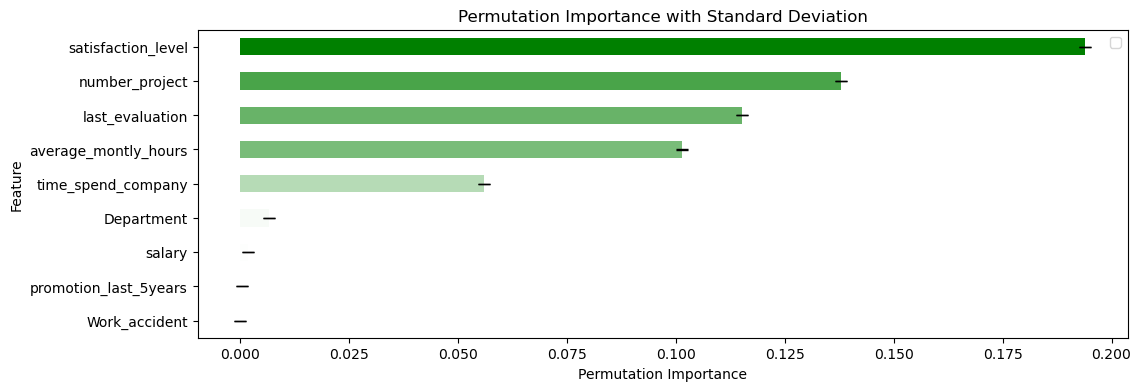

In [ ]:
# Feature Importance
cmap = LinearSegmentedColormap.from_list('Green',["w", "g"], N=256)

bagging_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                   ('classifier', BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_features=20, max_samples=1., 
                                                                    bootstrap_features=False, bootstrap=True, random_state=42, verbose=0))])
bagging_pipeline.fit(X_train, y_train)

result = permutation_importance(bagging_pipeline, X_test, y_test, n_repeats=10, random_state=42)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean,  
                                   'Standard Deviation': result.importances_std}).sort_values('Importance', ascending=True)

feature_importance.plot(x = 'Feature', y = 'Importance', kind = 'barh', figsize = (12, 4), yerr='Standard Deviation', capsize=4, align='center', legend = False,
                        color = cmap(((feature_importance['Importance']-feature_importance['Importance'].min()) / feature_importance['Importance'].max() * 256
                                     ).map(int)))
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance with Standard Deviation')
plt.legend("")

plt.show()
#del(cmap, result, feature_importance, bagging_pipeline, y_pred)

In [ ]:
# Comparing Bagging and Random Forest (should be the same in theory)
# and evaluating the feature importance using the built-in Random Forest method

bagging_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                   ('classifier', BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_features=10, random_state=42))])
bagging_pipeline.fit(X_train, y_train)
y_pred_bagging = bagging_pipeline.predict(X_test)

random_forest_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                   ('classifier', RandomForestClassifier(n_estimators=500, max_features=10, random_state=42))])
random_forest_pipeline.fit(X_train, y_train)
y_pred_random_forest = random_forest_pipeline.predict(X_test)

print('Disagreement (in %) between Bagging and Random Forest: {} %'.format(round(100 * np.mean(y_pred_bagging != y_pred_random_forest), 2)))
print('Feature importances for Random Forest:')
display(pd.Series(random_forest_pipeline['classifier'].feature_importances_, 
                  index = preprocess_pipeline.fit(X_train).get_feature_names_out()).sort_values(ascending=False).to_frame('Feature Importance'))
del(bagging_pipeline, y_pred_bagging,random_forest_pipeline, y_pred_random_forest)

Disagreement (in %) between Bagging and Random Forest: 0.57 %
Feature importances for Random Forest:


,Feature Importance
numerical__satisfaction_level,0.387102
numerical__time_spend_company,0.175798
numerical__number_project,0.164467
numerical__average_montly_hours,0.130985
numerical__last_evaluation,0.115679
categorical__salary_low,0.003520
categorical__Department_technical,0.003193
numerical__Work_accident,0.002881
categorical__Department_sales,0.002774
categorical__salary_medium,0.002399


In [ ]:
# Bagging's F1-score as a function of Num. of Features and Num. of Estimators
D = dict()
for n_est, max_feat in itertools.product([500, 1000, 1500],[4, 9, 14]):
    bagging_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                       ('classifier', BaggingClassifier(DecisionTreeClassifier(), n_estimators=n_est, max_features=max_feat, max_samples=1., 
                                                                        bootstrap_features=False, bootstrap=True, random_state=42, verbose=0))])
    bagging_pipeline.fit(X_train, y_train)
    y_pred = bagging_pipeline.predict(X_test)
    print('n_estimators={}, max_features={}'.format(n_est, max_feat))
    D[(n_est, max_feat)]=round(f1_score(y_test, y_pred, average='binary'),4)
display(pd.Series(D.values(), index = pd.MultiIndex.from_tuples(D.keys(), names=['Num. of Estimators','Num. of Features'])).unstack([-1]))
del(D, n_est, max_feat, bagging_pipeline)

n_estimators=500, max_features=4
n_estimators=500, max_features=9
n_estimators=500, max_features=14
n_estimators=1000, max_features=4
n_estimators=1000, max_features=9
n_estimators=1000, max_features=14
n_estimators=1500, max_features=4
n_estimators=1500, max_features=9
n_estimators=1500, max_features=14


Num. of Features,4,9,14
Num. of Estimators,,,
500,0.7250,0.9604,0.9763
1000,0.6895,0.9604,0.9770
1500,0.6944,0.9604,0.9770


In [ ]:
# Out-of-bag (validation) score
bagging_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                   ('classifier', BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_features=10, max_samples=1., 
                                                                    bootstrap_features=False, bootstrap=True, random_state=42, verbose=0,
                                                                    oob_score=True))])
bagging_pipeline.fit(X_train, y_train)
print('Out-of-bag score: {} %'.format(round(100 * bagging_pipeline["classifier"].oob_score_, 3)))
del(bagging_pipeline)

Out-of-bag score: 98.792 %


## AdaBoost

In [ ]:
ada_boost_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                     ('classifier', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5, random_state=42))])
ada_boost_pipeline.fit(X_train, y_train)

y_pred = ada_boost_pipeline.predict(X_test)
print("Bagging accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
del(ada_boost_pipeline, y_pred)

c:\Users\stani\Anaconda3\envs\my_env\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Bagging accuracy: 0.9610
Confusion matrix:
[[2240   54]
 [  63  643]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2294
           1       0.92      0.91      0.92       706

    accuracy                           0.96      3000
   macro avg       0.95      0.94      0.95      3000
weighted avg       0.96      0.96      0.96      3000



In [ ]:
# Various scores and averages for the varying maximal depth
D = dict()
for md in range(1, 6):
    print('Maximal depth: {}'.format(md))
    for score, averaging in itertools.product([f1_score, precision_score, recall_score],['binary','macro','micro','weighted']):
        ada_boost_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                             ('classifier', AdaBoostClassifier(DecisionTreeClassifier(max_depth=md), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5, random_state=42))])
        ada_boost_pipeline.fit(X_train, y_train)
        y_pred = ada_boost_pipeline.predict(X_test)        
        D[(score.__name__, averaging, md)] = round(score(y_test, y_pred, average=averaging), 4)
display(pd.Series(D.values(), index = pd.MultiIndex.from_tuples(D.keys(), names=['Score','Averaging','Maximal_Depth'])).unstack([-1]))
del(D, md, score, averaging, ada_boost_pipeline, y_pred)

Maximal depth: 1
Maximal depth: 2
Maximal depth: 3
Maximal depth: 4
Maximal depth: 5


Maximal_Depth                   1       2       3       4       5
Score           Averaging                                        
f1_score        binary     0.9166  0.9502  0.9687  0.9721  0.9721
                macro      0.9456  0.9675  0.9796  0.9818  0.9818
                micro      0.9610  0.9767  0.9853  0.9870  0.9870
                weighted   0.9609  0.9766  0.9853  0.9870  0.9870
precision_score binary     0.9225  0.9543  0.9729  0.9812  0.9812
                macro      0.9476  0.9689  0.9810  0.9850  0.9850
                micro      0.9610  0.9767  0.9853  0.9870  0.9870
                weighted   0.9608  0.9766  0.9853  0.9870  0.9870
recall_score    binary     0.9108  0.9462  0.9646  0.9632  0.9632
                macro      0.9436  0.9661  0.9782  0.9788  0.9788
                micro      0.9610  0.9767  0.9853  0.9870  0.9870
                weighted   0.9610  0.9767  0.9853  0.9870  0.9870

In [ ]:
# Various scores and averages for the varying number of estimators
D = dict()
for ne in [150, 250, 350, 450]:
    print('Number of Estimators: {}'.format(ne))
    for score, averaging in itertools.product([f1_score, precision_score, recall_score],['binary','macro','micro','weighted']):
        ada_boost_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                             ('classifier', AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=ne, algorithm="SAMME.R", learning_rate=0.5, random_state=42))])
        ada_boost_pipeline.fit(X_train, y_train)
        y_pred = ada_boost_pipeline.predict(X_test)        
        D[(score.__name__, averaging, ne)] = round(score(y_test, y_pred, average=averaging), 4)
display(pd.Series(D.values(), index = pd.MultiIndex.from_tuples(D.keys(), names=['Score','Averaging','Number of Estimators'])).unstack([-1]))
del(D, ne, score, averaging, ada_boost_pipeline, y_pred)

Number of Estimators: 150
Number of Estimators: 250
Number of Estimators: 350
Number of Estimators: 450


Number of Estimators          150     250     350     450
Score           Averaging                                
f1_score        binary     0.9471  0.9516  0.9552  0.9575
                macro      0.9655  0.9684  0.9707  0.9722
                micro      0.9753  0.9773  0.9790  0.9800
                weighted   0.9753  0.9773  0.9790  0.9800
precision_score binary     0.9553  0.9557  0.9599  0.9575
                macro      0.9683  0.9698  0.9724  0.9722
                micro      0.9753  0.9773  0.9790  0.9800
                weighted   0.9752  0.9773  0.9789  0.9800
recall_score    binary     0.9391  0.9476  0.9504  0.9575
                macro      0.9628  0.9670  0.9691  0.9722
                micro      0.9753  0.9773  0.9790  0.9800
                weighted   0.9753  0.9773  0.9790  0.9800

In [ ]:
# Various scores and averages for the varying learning rate
D = dict()
for lr in [.2, 0.5, 0.7]:
    print('Learning rate: {}'.format(lr))
    for score, averaging in itertools.product([f1_score, precision_score, recall_score],['binary','macro','micro','weighted']):
        ada_boost_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                             ('classifier', AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=200, algorithm="SAMME.R", learning_rate=lr, random_state=42))])
        ada_boost_pipeline.fit(X_train, y_train)
        y_pred = ada_boost_pipeline.predict(X_test)        
        D[(score.__name__, averaging, lr)] = round(score(y_test, y_pred, average=averaging), 4)
display(pd.Series(D.values(), index = pd.MultiIndex.from_tuples(D.keys(), names=['Score','Averaging','Learning rate'])).unstack([-1]))
del(D, lr, score, averaging, ada_boost_pipeline, y_pred)

Learning rate: 0.2
Learning rate: 0.5
Learning rate: 0.7


Learning rate                 0.2     0.5     0.7
Score           Averaging                        
f1_score        binary     0.9468  0.9502  0.9537
                macro      0.9654  0.9675  0.9698
                micro      0.9753  0.9767  0.9783
                weighted   0.9752  0.9766  0.9783
precision_score binary     0.9606  0.9543  0.9585
                macro      0.9702  0.9689  0.9714
                micro      0.9753  0.9767  0.9783
                weighted   0.9752  0.9766  0.9783
recall_score    binary     0.9334  0.9462  0.9490
                macro      0.9608  0.9661  0.9682
                micro      0.9753  0.9767  0.9783
                weighted   0.9753  0.9767  0.9783

## XGBoost

In [ ]:
xg_boost =  xgboost.XGBClassifier(enable_categorical=True, random_state=42, gamma=0., reg_alpha=0., reg_lambda=100.)
xg_boost.fit(X_train.apply(lambda col: col.astype('category') if col.dtype == 'object' else col, axis = 0), y_train)

y_pred = xg_boost.predict(X_test.apply(lambda col: col.astype('category') if col.dtype == 'object' else col, axis = 0))

print("Bagging accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
del(xg_boost, y_pred)

Bagging accuracy: 0.9773
Confusion matrix:
[[2283   11]
 [  57  649]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2294
           1       0.98      0.92      0.95       706

    accuracy                           0.98      3000
   macro avg       0.98      0.96      0.97      3000
weighted avg       0.98      0.98      0.98      3000



In [ ]:
D = dict()
for g, a, l in itertools.product(range(0,11),[0., 5., 10.], [0., 5., 10.]):
    xg_boost =  xgboost.XGBClassifier(enable_categorical=True, random_state=42, gamma=g, reg_alpha=a, reg_lambda=l)
    xg_boost.fit(X_train.apply(lambda col: col.astype('category') if col.dtype == 'object' else col, axis = 0), y_train)

    y_pred = xg_boost.predict(X_test.apply(lambda col: col.astype('category') if col.dtype == 'object' else col, axis = 0))    
    D[(g, a, l)] = round(f1_score(y_test, y_pred, average='binary'), 4)
display(pd.Series(D.values(), index = pd.MultiIndex.from_tuples(D.keys(), names=['Gamma','Reg. Alpha','Reg. Lambda'])).unstack([0]))
del(D, g, a, l, xg_boost, y_pred)

Gamma                       0       1       2       3       4       5   \
Reg. Alpha Reg. Lambda                                                   
0.0        0.0          0.9764  0.9609  0.9549  0.9533  0.9527  0.9447   
           5.0          0.9634  0.9490  0.9457  0.9433  0.9440  0.9440   
           10.0         0.9647  0.9459  0.9448  0.9455  0.9439  0.9424   
5.0        0.0          0.9534  0.9457  0.9418  0.9425  0.9432  0.9432   
           5.0          0.9504  0.9456  0.9433  0.9453  0.9439  0.9425   
           10.0         0.9526  0.9470  0.9446  0.9424  0.9424  0.9416   
10.0       0.0          0.9464  0.9425  0.9432  0.9416  0.9386  0.9402   
           5.0          0.9487  0.9393  0.9400  0.9385  0.9373  0.9380   
           10.0         0.9464  0.9408  0.9393  0.9393  0.9378  0.9355   

Gamma                       6       7       8       9       10  
Reg. Alpha Reg. Lambda                                          
0.0        0.0          0.9495  0.9426  0.9433  0.9409  0.9423  
           5.0          0.9446  0.9437  0.9439  0.9425  0.9408  
           10.0         0.9430  0.9439  0.9431  0.9439  0.9431  
5.0        0.0          0.9425  0.9402  0.9431  0.9423  0.9401  
           5.0          0.9425  0.9408  0.9399  0.9391  0.9384  
           10.0         0.9377  0.9380  0.9362  0.9355  0.9363  
10.0       0.0          0.9387  0.9379  0.9372  0.9348  0.9334  
           5.0          0.9372  0.9357  0.9341  0.9355  0.9355  
           10.0         0.9376  0.9378  0.9364  0.9357  0.9350